# **Abstract**

본 코드는 연구개발특구진흥재단 및 한국원자력연구원(KAERI)에서 주최하고, 데이콘에서 주관하며, (주)에넨에스에서 후원한 "태양광 발전량 예측 AI 경진대회"의 최종 제출 파일(try270_submission (2).csv)에 대한 복원 코드입니다. 다만, 본 코드로 산출되는 정답 파일은 기존의 제출물보다 Public Score가 약간 낮아 최종 선택하지는 않았습니다.

Autoregressive-ConvLSTM에 기초한 서로 다른 두 가지 모델 구조를 앙상블 하였으며, 리브-p-아웃 교차 검증을 적용하여 과적합을 방지하고자 하였습니다. Image blending을 이용한 데이터 증식을 수행하였고, adabelief 옵티마이저를 적용하여 adam 대비 수렴 속도를 높였습니다.

모든 실험 결과는 아래 주소의 tensorboard.dev에 업로드 되어있으며, Colab에서 3개의 활성화 창을 사용하여 동시에 훈련하였기 때문에 시간 순서는 폴드 순서와 일치하지 않을 수 있습니다.

*https://tensorboard.dev/experiment/V7U6FYk2Srq4r44MDjFNBg/*

# **Summary**

**실험 환경**

* Python: 3.6.9
* ML Framework: tensorflow-gpu 2.4.0 / tensorflow-addons 0.12.0
* GPU: Tesla V100 (16G)
* RAM: 25G


**전처리**

* DAY_SIN, DAY_COS 특징값을 추가하여 일별 주기성 확립
* 특징값 T를 절대온도 K로 변환
* 정규화(normalize or standarize)는 수행하지 않음
* 하루 단위(48개)로 shifting하며 9일 단위로 윈도우 분할 후 7일은 입력, 2일은 출력으로 사용
* 두 윈도우의 산술/기하평균을 추가해주는 방식으로 시계열 데이터 증식 (blending)


**모델 설계**

* ConvLSTM을 이용한 자기회귀(Autoregressive) 모델 생성
    - inp: \[batch, 7, 48, n_features\], tar: \[batch, 2, 48, 1\]
    - 하루 단위로 TARGET을 찍어내기 때문에 30분 단위로 계산하는 LSTM보다 학습 속도 및 사용 메모리 측면에서 이점을 가짐
* Conv1DLSTM 모델과 Conv2DLSTM + Residual 모델을 앙상블하여 적용
   - Conv1DLSTM 모델은 낮은 quantile (tau) 값에서 좋은 성능을 보임
   - Conv2DLSTM + Residual 모델은 높은 quantile (tau) 값에서 좋은 성능을 보임
   - 앙상블 방법으로, 두 모델의 출력을 bias가 제거된 FC로 연결하고, 초기 가중치를 tau에 따라 미리 설정함으로써 해당 앙상블 모델이 집중해야 할 하위 모델을 강제로 지정
* 각 tau에 대해 각각 1개씩 모델을 생성하여 훈련 (하나의 제출물을 위해 총 9개 모델 훈련)


**모델 훈련**

* 옵티마이저로는 Adabelief 사용 (Adam보다 수렴속도가 더 빨랐음)
* 학습률 스케줄러로는 Cosine Decay Restart에 Warmup 추가
* Epoch 75,Batch size 128 적용


**교차 검증**

* 리브-p-아웃 교차 검증을 응용하여 적용
   - 단순히 5-Fold 교차검증을 수행할 경우 각 폴드별 손실값이 매우 상이하였는데, 하나의 Validation Dataset에 최소 1년동안의 데이터가 포함되지 않아서 발생한 것으로 판단함
   - 이를 극복하기 위해 전체 3년치 데이터를 6분할 한 뒤, 상반기(1-6월)와 하반기(7-12월) 데이터를 각각 1개씩 고르는 방식으로 Validation Dataset 구성 (총 9개 데이터 세트 쌍 생성)
* 실험 과정 및 결과는 tensorboard.dev에 업로드 하였으며, Colab에서 3개의 활성화 창을 이용하여 동시에 훈련하였기 때문에 시간 순서는 맞지 않을 수 있음
   - *https://tensorboard.dev/experiment/V7U6FYk2Srq4r44MDjFNBg/*



**후처리**

* over/under forecast를 강제하고자 낮은 quantile 에서는 9개 결괏값 중 낮은 값 일부를, 높은 quantile 에서는 높은 값의 일부를 선택
* 전체 데이터 세트의 0 아닌 최솟값을 epsilon으로 지정하고, 모델의 결과값 중 epsilon/2보다 낮은 값들은 0으로 치환

# **Default Setting**

In [ ]:
!pip3 install -q --upgrade tensorflow-addons
!pip3 install -q adabelief-tf

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%env NOTEBOOKNAME try270
%env LOCAL_DATA_PATH /content/drive/MyDrive/dacon/dacon-sunlight/data
%env CHECKPOINT_PATH /content/drive/MyDrive/dacon/dacon-sunlight/ckpt
%env SUBMISSION_PATH /content/drive/MyDrive/dacon/dacon-sunlight/submission
%env TENSORBOARD_PATH /content/drive/MyDrive/dacon/dacon-sunlight/logs/fit

env: NOTEBOOKNAME=try270
env: LOCAL_DATA_PATH=/content/drive/MyDrive/dacon/dacon-sunlight/data
env: CHECKPOINT_PATH=/content/drive/MyDrive/dacon/dacon-sunlight/ckpt
env: SUBMISSION_PATH=/content/drive/MyDrive/dacon/dacon-sunlight/submission
env: TENSORBOARD_PATH=/content/drive/MyDrive/dacon/dacon-sunlight/logs/fit


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

import datetime
import glob
import itertools
import os
import re

import numpy as np
import pandas as pd

from adabelief_tf import AdaBeliefOptimizer
from matplotlib import pyplot as plt

print(f"tf.__version__: {tf.__version__}")
print(f"tfa.__version__: {tfa.__version__}")

In [ ]:
# If you wanna avoid below error, you need to run below codes when you start kernel.

# UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, 
# so try looking to see if a warning log message was printed above. [Op:Conv2D]

# Ref: https://blog.naver.com/vft1500/221793591386

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs.")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs.


In [ ]:
# !python -V

In [ ]:
# !cat /proc/cpuinfo

In [ ]:
# !nvidia-smi

In [ ]:
# !df -h

In [ ]:
# !free -h

# **Define Arguments**

In [ ]:
class HParams(object):
    def __init__(self):
        # Basic.
        self.seed = 42
        self.test_size = 0.2
        self.epoch = 75
        self.warmup_epoch = 5
        self.lr = 3e-3
        self.min_lr = 1e-4
        
        self.decay_steps = 10
        self.t_mul = 2.0
        self.m_mul = 0.5
        self.alpha = self.min_lr / self.lr
        
        # Dataframe.        
        self.feature_dict = {}
        self.num_test_csv = 81
        self.day_split = 1
        self.day = 48
        self.inp = 7
        self.tar = 2

        self.num_features = 8
        self.num_quantile = 9

        # K-Fold CV.
        self.fore = 31 + 28 + 31 + 30 + 31 + 30 # January ~ June
        self.rear = 31 + 31 + 30 + 31 + 30 + 31 # July ~ December
        self.n_year = 3

        self.fold = 9
        self.fold_split = self.day * np.cumsum([0] + [self.fore, self.rear] * self.n_year) # 6 folds, not 9 folds
        
        # Dataset Pipeline.
        self.w_inp = self.inp * self.day
        self.w_tar = self.tar * self.day
        self.w_shift = self.day
        self.w_stride = 1
        self.w_dr = True
        
        self.num_mixup = 2

        self.shuffle_buffer_sz = 100_000
        
        self.auto = tf.data.experimental.AUTOTUNE
        
        self.global_batch_size = 128
        
        # Modeling.
        self.input_shape = [self.inp, self.day, self.num_features]
        self.input_dtype = tf.dtypes.float32
        self.units = 64
        self.out_steps = self.tar
        self.dropout_rate = 0.4
        self.activation = tf.keras.activations.relu
        
        self.nrm_kernel_sz = (9, 1)
        self.nrm_dilation_rate = (2, 1)
        
        self.rm_kernel_sz = (3, 3)
        self.rm_dilation_rate = (1, 1)
        
        # Remove checkpoints.
        self.max_to_keep = 3
        
        
HPARAMS = HParams()

# **Load Datasets**

## **Define Preprocessing Funciton**

In [ ]:
def preprocess(
    df: pd.DataFrame, 
) -> pd.DataFrame:
    """Preprocess dataframes without any normalize."""
    
    # Timestamp to signals.
    time = 2 * np.int64(df["Hour"]) + (np.int64(df["Minute"]) // 30)
    df.insert(loc = 0, column = "Time", value = time)
    
    day_sin = np.sin(df["Time"] * (2 * np.pi / HPARAMS.day)) / 2 + 0.5 # range: [0, 1]
    day_cos = np.cos(df["Time"] * (2 * np.pi / HPARAMS.day)) / 2 + 0.5 # range: [0, 1]
        
    df.insert(loc = 0, column = "DAY_SIN", value = day_sin)
    df.insert(loc = 1, column = "DAY_COS", value = day_cos)
    
    # Kelvim Temperature.
    kelvin = df["T"] + 273.15
    df.insert(loc = 11, column = "K", value = kelvin)
    
    df = df.drop(["Day", "Hour", "Minute", "Time", "T"], axis = 1)
    
    return df

## **Train & Validation Dataframes**

In [ ]:
df = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "train", "train.csv"))
df = preprocess(df)

# 6-Fold split.
dfs = [df.iloc[i:j] for i, j in zip(HPARAMS.fold_split[:-1], HPARAMS.fold_split[1:])]
assert not np.any([foo.shape[0] % HPARAMS.day for foo in dfs]) # df.shape[0] % 48 must be zero.

for fold, df in enumerate(dfs):
    print(f"The shape of fold #{fold}: {df.shape}")

The shape of fold #0: (8688, 8)
The shape of fold #1: (8832, 8)
The shape of fold #2: (8688, 8)
The shape of fold #3: (8832, 8)
The shape of fold #4: (8688, 8)
The shape of fold #5: (8832, 8)


## **Test Dataframe**

In [ ]:
ts_filenames = [os.path.join(os.environ["LOCAL_DATA_PATH"], "test", f"{i}.csv") for i in range(HPARAMS.num_test_csv)]
ts_dfs = [preprocess(pd.read_csv(ts_filename)) for ts_filename in ts_filenames]
ts_df = pd.concat(ts_dfs)

print(f"ts_df.shape: {ts_df.shape}, columns: {','.join(ts_df.columns)}")

ts_df.shape: (27216, 8), columns: DAY_SIN,DAY_COS,DHI,DNI,WS,RH,K,TARGET


# **Make Dataset Pipelines**

In [ ]:
@tf.function
def _flat_fn_tr(x):
    return x.batch(HPARAMS.w_inp + HPARAMS.w_tar)


@tf.function
def _flat_fn_ts(x):
    return x.batch(HPARAMS.w_inp)


@tf.function
def _blending(features):
    """
         input: (2, 432, 8)
        output: (4, 432, 8)
    """
    img1, img2 = tf.unstack(features, axis = 0)
    a_mean = (img1 + img2) / 2
    g_mean = tf.math.sqrt(img1 * img2)
    return tf.stack([img1, img2, a_mean, g_mean], axis = 0)


@tf.function
def _reshape_tr(features):
    """
         input: (batch, 432, 8)
        output: (batch, 9, 48, 8)
    """
    return tf.reshape(features, (-1, HPARAMS.inp + HPARAMS.tar, HPARAMS.day, HPARAMS.num_features))


@tf.function
def _reshape_ts(features):
    """
         input: (batch, 336, 8)
        output: (batch, 7, 48, 8)
    """
    return tf.reshape(features, (-1, HPARAMS.inp, HPARAMS.day, HPARAMS.num_features))


@tf.function
def _split_window_tr(features):
    """
         input: (batch, 9, 48, 8)
        output: (batch, 7, 48, 8), (batch, 2, 48, 1)
    """
    inp, tar = tf.split(features, [HPARAMS.inp, HPARAMS.tar], axis = 1)
    _, tar = tf.split(tar, [-1, 1], axis = -1)
    return inp, tar

In [ ]:
def make_datasets(
    dfs: list,
) -> tuple:
    """Make k-fold to cross validation."""

    datasets = []
    for fold, df in enumerate(dfs):
        tensor = tf.constant(df, dtype = tf.float32)
        dataset = tf.data.Dataset.from_tensor_slices(tensor
                      ).window(HPARAMS.w_inp + HPARAMS.w_tar, HPARAMS.w_shift, HPARAMS.w_stride, HPARAMS.w_dr
                      ).flat_map(_flat_fn_tr)
        datasets.append(dataset)
        
    
    vl_idx_list = [list(i) for i in itertools.product(*[range(0, len(dfs), 2), range(1, len(dfs), 2)])]
    tr_idx_list = [list(set(range(0, len(dfs), 1)) - set(vl_idx)) for vl_idx in vl_idx_list]
    assert len(vl_idx_list) == HPARAMS.fold
    assert len(tr_idx_list) == HPARAMS.fold

    tr_datasets, vl_datasets = [], []

    for tr_idx, vl_idx in zip(tr_idx_list, vl_idx_list):
        # Concat datasets.
        for ds in np.array(datasets)[tr_idx]:
            try:
                tr_dataset = tr_dataset.concatenate(ds)
            except:
                tr_dataset = ds
        
        for ds in np.array(datasets)[vl_idx]:
            try:
                vl_dataset = vl_dataset.concatenate(ds)
            except:
                vl_dataset = ds


        tr_dataset = tr_dataset.cache(
                        ).shuffle(HPARAMS.shuffle_buffer_sz, reshuffle_each_iteration = True
                        ).batch(HPARAMS.num_mixup, drop_remainder = True
                        ).map(_blending, num_parallel_calls = HPARAMS.auto).unbatch(
                        ).shuffle(HPARAMS.shuffle_buffer_sz, reshuffle_each_iteration = True # reshuffle
                        ).batch(HPARAMS.global_batch_size
                        ).map(_reshape_tr, num_parallel_calls = HPARAMS.auto
                        ).map(_split_window_tr, num_parallel_calls = HPARAMS.auto
                        ).prefetch(HPARAMS.auto)
        
        # Validation dataset.
        vl_dataset = vl_dataset.cache(
                        ).batch(HPARAMS.global_batch_size
                        ).map(_reshape_tr, num_parallel_calls = HPARAMS.auto
                        ).map(_split_window_tr, num_parallel_calls = HPARAMS.auto
                        ).prefetch(HPARAMS.auto)
        
        tr_datasets.append(tr_dataset)
        vl_datasets.append(vl_dataset)
    
    return tr_datasets, vl_datasets

In [ ]:
tr_datasets, vl_datasets = make_datasets(dfs)
tr_datasets, vl_datasets

([<PrefetchDataset shapes: ((None, 7, 48, 8), (None, 2, 48, 1)), types: (tf.float32, tf.float32)>,
  <PrefetchDataset shapes: ((None, 7, 48, 8), (None, 2, 48, 1)), types: (tf.float32, tf.float32)>,
  <PrefetchDataset shapes: ((None, 7, 48, 8), (None, 2, 48, 1)), types: (tf.float32, tf.float32)>,
  <PrefetchDataset shapes: ((None, 7, 48, 8), (None, 2, 48, 1)), types: (tf.float32, tf.float32)>,
  <PrefetchDataset shapes: ((None, 7, 48, 8), (None, 2, 48, 1)), types: (tf.float32, tf.float32)>,
  <PrefetchDataset shapes: ((None, 7, 48, 8), (None, 2, 48, 1)), types: (tf.float32, tf.float32)>,
  <PrefetchDataset shapes: ((None, 7, 48, 8), (None, 2, 48, 1)), types: (tf.float32, tf.float32)>,
  <PrefetchDataset shapes: ((None, 7, 48, 8), (None, 2, 48, 1)), types: (tf.float32, tf.float32)>,
  <PrefetchDataset shapes: ((None, 7, 48, 8), (None, 2, 48, 1)), types: (tf.float32, tf.float32)>],
 [<PrefetchDataset shapes: ((None, 7, 48, 8), (None, 2, 48, 1)), types: (tf.float32, tf.float32)>,
  <Prefet

In [ ]:
# Dataframe to tensor. (TARGET column located on axis = -1)
ts_tensor = tf.constant(ts_df, dtype = tf.float32)

ts_dataset = tf.data.Dataset.from_tensor_slices(ts_tensor
                    ).window(HPARAMS.w_inp, HPARAMS.w_inp, 1, HPARAMS.w_dr).flat_map(_flat_fn_ts
                    ).cache(
                    ).batch(HPARAMS.num_test_csv # not HPARAMS.global_batch_size
                    ).map(_reshape_ts, num_parallel_calls = HPARAMS.auto
                    ).prefetch(HPARAMS.auto)

print(ts_dataset)

<PrefetchDataset shapes: (None, 7, 48, 8), types: tf.float32>


## **Take Samples**

In [ ]:
%%time
print(f"Training Dataset...")
for fold, tr_dataset in enumerate(tr_datasets):
    print(f"# of fold {fold}: {len(list(tr_dataset.unbatch().as_numpy_iterator()))}")

print(f"\nValidation Dataset...")
for fold, vl_dataset in enumerate(vl_datasets):
    print(f"# of fold {fold}: {len(list(vl_dataset.unbatch().as_numpy_iterator()))}")    

Training Dataset...
# of fold 0: 1396
# of fold 1: 1396
# of fold 2: 1396
# of fold 3: 1396
# of fold 4: 1396
# of fold 5: 1396
# of fold 6: 1396
# of fold 7: 1396
# of fold 8: 1396

Validation Dataset...
# of fold 0: 349
# of fold 1: 349
# of fold 2: 349
# of fold 3: 349
# of fold 4: 349
# of fold 5: 349
# of fold 6: 349
# of fold 7: 349
# of fold 8: 349
CPU times: user 3.35 s, sys: 193 ms, total: 3.54 s
Wall time: 2.9 s


# **Create Network**

## **Basic AR-ConvLSTM Model**

In [ ]:
class AR_ConvLSTM(tf.keras.Model):
    def __init__(
        self, 
        model_name: str,
        units: int,
        kernel_sz: tuple,
        dilation_rate: tuple,
        out_steps: int = HPARAMS.out_steps,
        dropout_rate: float = HPARAMS.dropout_rate,
        day: int = HPARAMS.day,
        use_bn: bool = False,
        activation: tf.keras.activations = HPARAMS.activation,
    ):
        super(AR_ConvLSTM, self).__init__(name = model_name)
        
        self.units = units        
        self.kernel_sz = kernel_sz
        self.dilation_rate = dilation_rate
        
        self.out_steps = out_steps
        self.dropout_rate = dropout_rate
        self.day = day
        self.use_bn = use_bn
        self.activation = activation
        
        if self.use_bn:
            self.stem = tf.keras.layers.TimeDistributed(tf.keras.Sequential([
                tf.keras.layers.Conv2D(
                    self.units, self.kernel_sz, dilation_rate = self.dilation_rate, 
                    padding = "same", activation = self.activation),
                tf.keras.layers.BatchNormalization()]))
        else:
            self.stem = tf.keras.layers.TimeDistributed(tf.keras.Sequential([
                tf.keras.layers.Conv2D(
                    self.units, self.kernel_sz, dilation_rate = self.dilation_rate, 
                    padding = "same", activation = self.activation)])) # no bn

        self.convlstm = tf.keras.layers.ConvLSTM2D(
            self.units, self.kernel_sz, dilation_rate = self.dilation_rate, 
            padding = "same", dropout = self.dropout_rate, return_state = True)
        self.expand_timestamp_dim = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = 1))
        self.expand_channel_dim = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1))
        
        
    @tf.function
    def warmup(
        self, 
        inputs,
    ):
        """
             inputs: (batch, 7, 48, num_features, units)
            outputs: (batch, 48, num_features, units)
        """
        x, *state = self.convlstm(inputs)
        return x, state
    
    
    @tf.function
    def call(
        self, 
        inputs, 
        training = None,
    ):
        """
             inputs: (batch, 7, 48, num_features)
            outputs: (batch, 2, 48, num_features, units)
        """
        outputs = tf.TensorArray(tf.float32, size = self.out_steps) #, dynamic_size = False)
        
        # Stem.
        x = self.expand_channel_dim(inputs)
        x = self.stem(x)
        
        # Warm up.
        x, state = self.warmup(x)
        outputs = outputs.write(0, x)
        
        # Autoregressive loops.
        for n in tf.range(1, self.out_steps):
            x = self.expand_timestamp_dim(x)
            x, *state = self.convlstm(x, initial_state = state)
            outputs = outputs.write(n, x)
        
        return tf.transpose(outputs.stack(), [1, 0, 2, 3, 4])        

## **Non-Residual Model**

In [ ]:
def Non_Residual_Model(
    model_name: str,
    units: int = HPARAMS.units,
    kernel_sz: tuple = HPARAMS.nrm_kernel_sz,
    dilation_rate: tuple = HPARAMS.nrm_dilation_rate,
    out_steps: int = HPARAMS.out_steps,
    dropout_rate: float = HPARAMS.dropout_rate,
    day: int = HPARAMS.day,
    activation = HPARAMS.activation,
) -> tf.keras.Model:
    """Create an emsembled ar-convlstm model by feature-wise."""
    
    model_input = tf.keras.layers.Input(shape = HPARAMS.input_shape, dtype = HPARAMS.input_dtype)
 
    # Only DNI, DHI, TARGET features will be used.
    xs = tf.keras.layers.Lambda(lambda x: tf.split(x, x.shape[-1], axis = -1), name = "feature-wised_split")(model_input)
    xs = [xs[2], xs[3], xs[7]] 

    submodels = [
        AR_ConvLSTM(f"{model_name}_DHI", units, kernel_sz, dilation_rate),
        AR_ConvLSTM(f"{model_name}_DNI", units, kernel_sz, dilation_rate),
        AR_ConvLSTM(f"{model_name}_TARGET", 2 * units, kernel_sz, dilation_rate)]
    
    # Prediction
    xs = [submodel(x) for submodel, x in zip(submodels, xs)]
    
    # Concat and re-prediction.
    x = tf.keras.layers.Concatenate(axis = -1)(xs)
    x = tf.keras.layers.Reshape((out_steps, day, -1))(x)
    
    x = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv1D(x.shape[-1], kernel_sz[0], padding = "same", activation = activation))(x)
    x = tf.keras.layers.SpatialDropout2D(dropout_rate)(x)
    
    model_output = tf.keras.layers.Dense(1, activation = "relu")(x)
    
    return tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name)    

In [ ]:
tmp = Non_Residual_Model("tmp")
tmp.summary()

Model: "tmp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7, 48, 8)]   0                                            
__________________________________________________________________________________________________
feature-wised_split (Lambda)    [(None, 7, 48, 1), ( 0           input_1[0][0]                    
__________________________________________________________________________________________________
tmp_DHI (AR_ConvLSTM)           (None, 2, 48, 1, 64) 295808      feature-wised_split[0][2]        
__________________________________________________________________________________________________
tmp_DNI (AR_ConvLSTM)           (None, 2, 48, 1, 64) 295808      feature-wised_split[0][3]        
________________________________________________________________________________________________

In [ ]:
# tf.keras.utils.plot_model(tmp, show_layer_names = True, show_shapes = False)

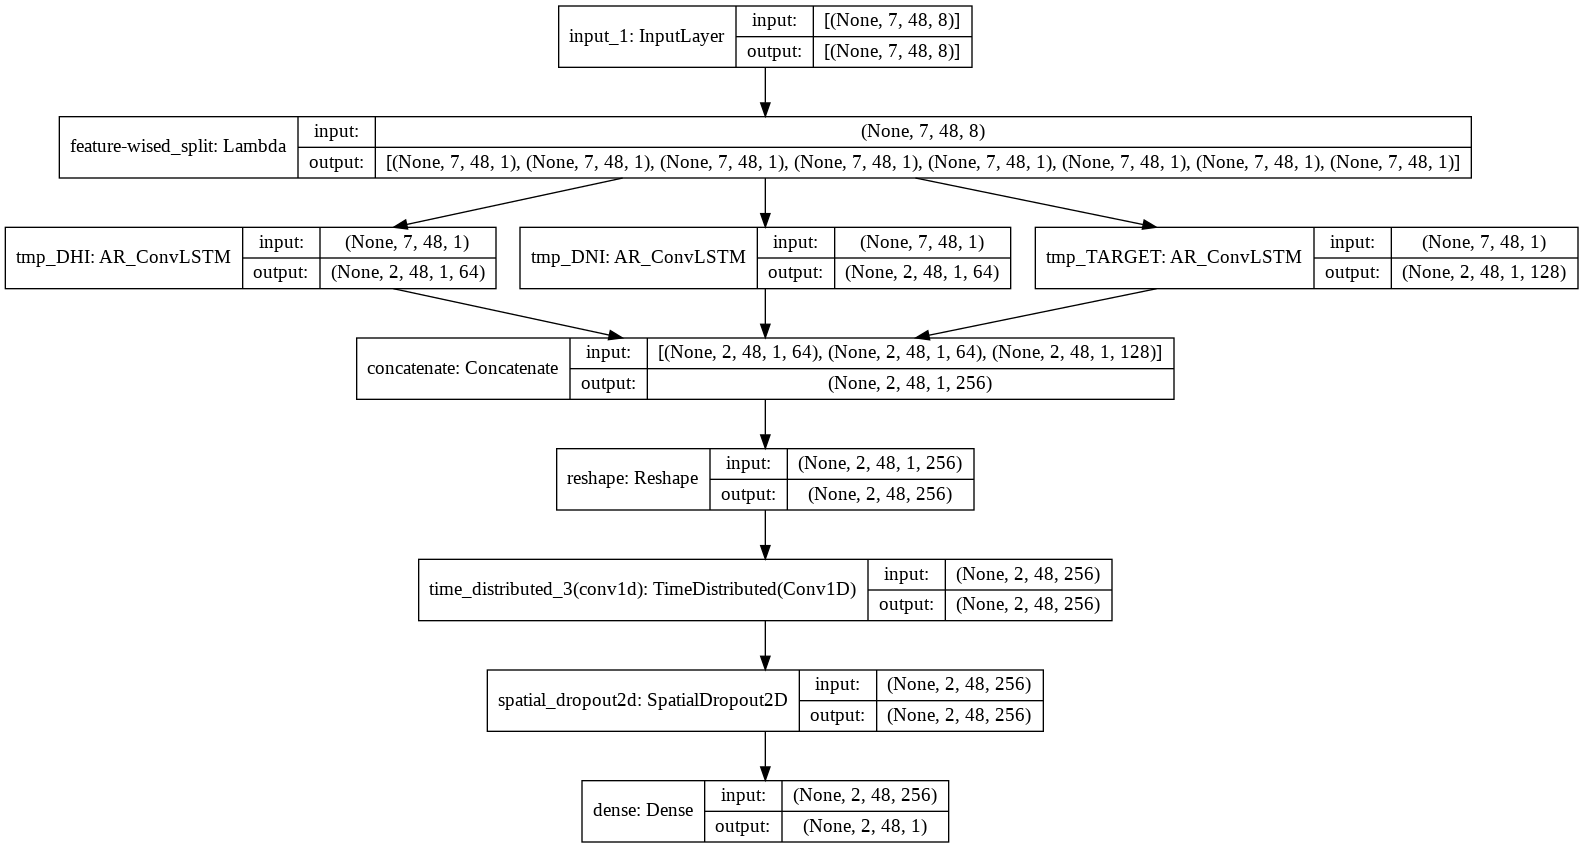

In [ ]:
tf.keras.utils.plot_model(tmp, show_shapes = True)

In [ ]:
del tmp

## **Residual Model**

In [ ]:
def Residual_Model(
    model_name: str,
    kernel_sz: tuple = HPARAMS.rm_kernel_sz,
    dilation_rate: tuple = HPARAMS.rm_dilation_rate,
    units: int = HPARAMS.units,
    out_steps: int = HPARAMS.out_steps,
    dropout_rate: float = HPARAMS.dropout_rate,
    day: int = HPARAMS.day,
    activation = HPARAMS.activation,
) -> tf.keras.Model:
    """Create an emsembled ar-convlstm model by feature-wise."""
   
    predict_delta = tf.keras.layers.TimeDistributed(tf.keras.Sequential([
        tf.keras.layers.SpatialDropout1D(dropout_rate),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(HPARAMS.num_features * units, activation = activation),
        tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.Zeros())], name = "predict_delta"))
    add = tf.keras.layers.Add(name = "residual_add")
    outputs = []
    
    # Entry Flow.
    model_input = tf.keras.layers.Input(shape = HPARAMS.input_shape, dtype = HPARAMS.input_dtype)
    
    # Middle Flow.
    x = AR_ConvLSTM(f"{model_name}_convlstm", units, kernel_sz, dilation_rate, use_bn = True)(model_input)
    xs = tf.keras.layers.Lambda(lambda x: tf.unstack(x, axis = 1), name = "unstack")(x)
    
    residual_seed = tf.keras.layers.Lambda(lambda x: x[:, -1, :, -1:], name = "residual_seed")(model_input)
    outputs.append(add([residual_seed, predict_delta(xs[0])]))
    
    # Cumulative sum of delta.
    for i in range(1, out_steps):
        outputs.append(add([outputs[-1], predict_delta(xs[i])]))

    # Exit flow.
    model_output = tf.keras.layers.Lambda(lambda x: tf.stack(x, axis = 1), name = "stack_output")(outputs)
    
    return tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name)

In [ ]:
tmp = Residual_Model("tmp")
tmp.summary()

Model: "tmp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 7, 48, 8)]   0                                            
__________________________________________________________________________________________________
tmp_convlstm (AR_ConvLSTM)      (None, 2, 48, 8, 64) 296064      input_2[0][0]                    
__________________________________________________________________________________________________
unstack (Lambda)                [(None, 48, 8, 64),  0           tmp_convlstm[0][0]               
__________________________________________________________________________________________________
residual_seed (Lambda)          (None, 48, 1)        0           input_2[0][0]                    
________________________________________________________________________________________________

In [ ]:
# tf.keras.utils.plot_model(tmp, show_layer_names = True, show_shapes = False)

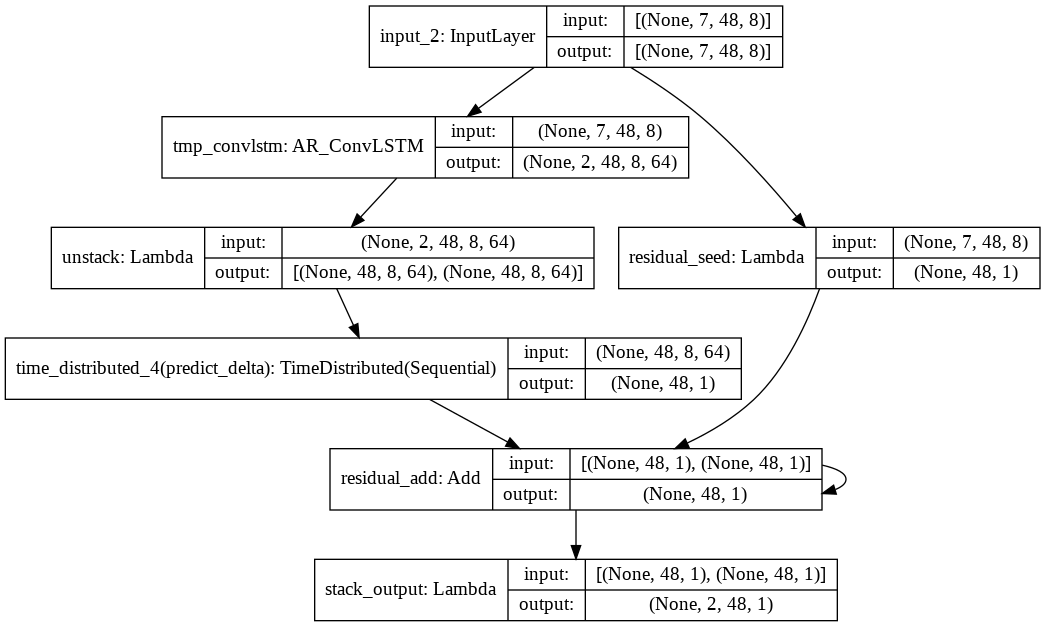

In [ ]:
tf.keras.utils.plot_model(tmp, show_shapes = True)

In [ ]:
del tmp

## **Ensembled Model**

In [ ]:
def CreateEnsembledModel(
    model_name: str,
    tau: float,
) -> tf.keras.Model:

    model_input = tf.keras.layers.Input(shape = HPARAMS.input_shape, dtype = HPARAMS.input_dtype)

    x1 = Non_Residual_Model(f"{model_name}_nrm")(model_input)
    x2 = Residual_Model(f"{model_name}_rm")(model_input)

    x = tf.keras.layers.Concatenate()([x1, x2])
    model_output = tf.keras.layers.Dense(1, use_bias = False)(x)

    model = tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name)
    
    # The lower the tau, the more the non-residual model and the higher the residual model.
    model.layers[-1].weights[0].assign([[1. - tau], [tau]])
    return model

In [ ]:
tmp = CreateEnsembledModel("tmp", tau = 0.1)
tmp.summary()

Model: "tmp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 7, 48, 8)]   0                                            
__________________________________________________________________________________________________
tmp_nrm (Functional)            (None, 2, 48, 1)     2363393     input_3[0][0]                    
__________________________________________________________________________________________________
tmp_rm (Functional)             (None, 2, 48, 1)     559233      input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 2, 48, 2)     0           tmp_nrm[0][0]                    
                                                                 tmp_rm[0][0]                   

In [ ]:
tmp.layers[-1].weights

[<tf.Variable 'dense_6/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[0.9],
        [0.1]], dtype=float32)>]

In [ ]:
del tmp

# **Compile and Fit**

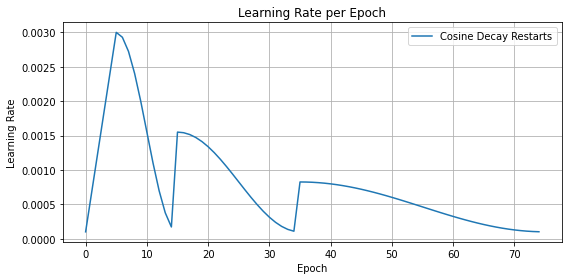

In [ ]:
lr_decayed_fn = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate = HPARAMS.lr,
    first_decay_steps = HPARAMS.decay_steps, 
    t_mul = HPARAMS.t_mul, 
    m_mul = HPARAMS.m_mul, 
    alpha = HPARAMS.alpha)


def scheduler(
    epoch, 
    lr
):
    if not epoch:
        return lr
    elif epoch <= HPARAMS.warmup_epoch:
        return lr + (HPARAMS.lr - HPARAMS.min_lr) / HPARAMS.warmup_epoch
    else:
        return lr_decayed_fn(epoch - HPARAMS.warmup_epoch).numpy()

    
lr = []
for step in range(HPARAMS.epoch):
    lr.append(scheduler(step, HPARAMS.min_lr if not step else lr[-1]))
    
plt.figure(figsize = (8, 4), facecolor = "white")
plt.plot(lr, label = "Cosine Decay Restarts")
plt.title("Learning Rate per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("lr.png")
plt.show()

In [ ]:
def get_callbacks(
    model_name: str,
) -> list:
    """Get some callbacks."""
    
    lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    
    # Checkpoint callback.
    ckpt_path = os.path.join(
        os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], 
        model_name, "cp-{epoch:03d}-{val_loss:.4f}.ckpt")
    ckpt_dir = os.path.dirname(ckpt_path)
    os.makedirs(ckpt_dir, exist_ok = True)
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, verbose = 0, monitor = "val_loss", save_weights_only = True, save_best_only = True)
    
    # TensorBoard callback.
    log_dir = os.path.join(
        os.environ["TENSORBOARD_PATH"], os.environ["NOTEBOOKNAME"], datetime.datetime.now().strftime(f"{model_name}-%Y%m%d-%H%M%S"))
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1, update_freq = "batch")
    
    return [lr_callback, cp_callback, tb_callback]
    

def compile_and_fit(
    model: tf.keras.Model, 
    tau: float, 
    tr_dataset: tf.data.Dataset, 
    vl_dataset: tf.data.Dataset, 
    epochs: int,
    lr: float,
    verbose: int = 0, 
) -> dict:
    """Compile and fit the model."""
        
    model.compile(
        loss = tfa.losses.PinballLoss(tau = tau),
        optimizer = AdaBeliefOptimizer(lr, print_change_log = False))
    
    print(f"Model {model.name}...")

    history = model.fit(
        tr_dataset,
        validation_data = vl_dataset,
        epochs = epochs,
        verbose = verbose,
        callbacks = get_callbacks(model.name))

    return history

In [ ]:
%%time

# 5-Fold.
for fold in [0, 1, 2]:
    # 9 models.
    for tau in np.arange(0.1, 1, 0.1):    
        model = CreateEnsembledModel(model_name = f"F{fold}_P{tau:.1f}", tau = tau)

        _ = compile_and_fit(
            model, 
            tau, 
            tr_datasets[fold], 
            vl_datasets[fold], 
            HPARAMS.epoch,
            HPARAMS.min_lr,
            verbose = 0)

        del model # for save memories

Model F0_P0.1...
Model F0_P0.2...
Model F0_P0.3...
Model F0_P0.4...
Model F0_P0.5...
Model F0_P0.6...
Model F0_P0.7...
Model F0_P0.8...
Model F0_P0.9...
Model F1_P0.1...
Model F1_P0.2...
Model F1_P0.3...
Model F1_P0.4...
Model F1_P0.5...
Model F1_P0.6...
Model F1_P0.7...
Model F1_P0.8...
Model F1_P0.9...
Model F2_P0.1...
Model F2_P0.2...
Model F2_P0.3...
Model F2_P0.4...
Model F2_P0.5...
Model F2_P0.6...
Model F2_P0.7...
Model F2_P0.8...
Model F2_P0.9...
CPU times: user 3h 52min 22s, sys: 35min 6s, total: 4h 27min 29s
Wall time: 2h 48min 51s


In [ ]:
%%time

# 5-Fold.
for fold in [3, 4, 5]:
    # 9 models.
    for tau in np.arange(0.1, 1, 0.1):    
        model = CreateEnsembledModel(model_name = f"F{fold}_P{tau:.1f}", tau = tau)

        _ = compile_and_fit(
            model, 
            tau, 
            tr_datasets[fold], 
            vl_datasets[fold], 
            HPARAMS.epoch,
            HPARAMS.min_lr,
            verbose = 0)

        del model # for save memories

Model F3_P0.1...
Model F3_P0.2...
Model F3_P0.3...
Model F3_P0.4...
Model F3_P0.5...
Model F3_P0.6...
Model F3_P0.7...
Model F3_P0.8...
Model F3_P0.9...
Model F4_P0.1...
Model F4_P0.2...
Model F4_P0.3...
Model F4_P0.4...
Model F4_P0.5...
Model F4_P0.6...
Model F4_P0.7...
Model F4_P0.8...
Model F4_P0.9...
Model F5_P0.1...
Model F5_P0.2...
Model F5_P0.3...
Model F5_P0.4...
Model F5_P0.5...
Model F5_P0.6...
Model F5_P0.7...
Model F5_P0.8...
Model F5_P0.9...
CPU times: user 3h 48min 7s, sys: 34min 56s, total: 4h 23min 4s
Wall time: 2h 47min 31s


In [ ]:
%%time

# 5-Fold.
for fold in [6, 7, 8]:
    # 9 models.
    for tau in np.arange(0.1, 1, 0.1):    
        model = CreateEnsembledModel(model_name = f"F{fold}_P{tau:.1f}", tau = tau)

        _ = compile_and_fit(
            model, 
            tau, 
            tr_datasets[fold], 
            vl_datasets[fold], 
            HPARAMS.epoch,
            HPARAMS.min_lr,
            verbose = 0)

        del model # for save memories

Model F6_P0.1...
Model F6_P0.2...
Model F6_P0.3...
Model F6_P0.4...
Model F6_P0.5...
Model F6_P0.6...
Model F6_P0.7...
Model F6_P0.8...
Model F6_P0.9...
Model F7_P0.1...
Model F7_P0.2...
Model F7_P0.3...
Model F7_P0.4...
Model F7_P0.5...
Model F7_P0.6...
Model F7_P0.7...
Model F7_P0.8...
Model F7_P0.9...
Model F8_P0.1...
Model F8_P0.2...
Model F8_P0.3...
Model F8_P0.4...
Model F8_P0.5...
Model F8_P0.6...
Model F8_P0.7...
Model F8_P0.8...
Model F8_P0.9...
CPU times: user 3h 58min 3s, sys: 34min 15s, total: 4h 32min 18s
Wall time: 2h 51min 46s


In [ ]:
!tensorboard dev upload --logdir $TENSORBOARD_PATH/$NOTEBOOKNAME \
    --name "try270" \
    --description "Final experiment (try270) of dacon-sunlight competition." \
    --one_shot

2021-01-28 06:05:05.586486: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/drive/MyDrive/dacon/dacon-sunlight/logs/fit/try270

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.co

In [ ]:
!tensorboard dev list

2021-01-28 06:22:54.559047: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
https://tensorboard.dev/experiment/V7U6FYk2Srq4r44MDjFNBg/
	Name                 try270
	Description          Final experiment (try270) of dacon-sunlight competition.
	Id                   V7U6FYk2Srq4r44MDjFNBg
	Created              2021-01-28 06:05:51 (17 minutes ago)
	Updated              2021-01-28 06:21:31 (1 minute ago)
	Runs                 162
	Tags                 927
	Scalars              78975
	Tensor bytes         318375471
	Binary object bytes  601664490
Total: 1 experiment(s)


## **Make Clean Checkpoints**

In [ ]:
%%time

ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "*")))

num_rm_files = 0
rm_files_sz = 0 # bytes

for f in ckpt_folders:
    # 7 files must be located in ckpt_folders. (latest 3 ckpt, it's index and checkpoint file)
    assert len(os.listdir(f)) >= (1 + HPARAMS.max_to_keep * 2), f"Checkpoints in {f} is less then 3 (max_to_keep)."
    
    rm_files = [os.path.join(f, i) for i in sorted(os.listdir(f))[1:-2*HPARAMS.max_to_keep]] # [1:-6]
    num_rm_files += len(rm_files)
    rm_files_sz += sum([os.path.getsize(rm_file) for rm_file in rm_files])
    
    _ = [os.remove(rm_file) for rm_file in rm_files]
    
print(f"{num_rm_files} files removed.")
print(f"{rm_files_sz / 2**20:.2f}MB saved.")

1768 files removed.
29589.64MB saved.
CPU times: user 135 ms, sys: 559 ms, total: 693 ms
Wall time: 8.44 s


# **Make Submissions**

In [ ]:
def load_latest_models(
    ckpt_folders: list,
) -> list:
    """Load latest weights of target model from saved ckeckpoints."""   
    
    models = []
    val_losses = []
    
    for f in ckpt_folders:
        latest = tf.train.latest_checkpoint(f)
        print(f"Load latest checkpoints: {latest}...")
        
        model_name = latest.split(os.path.sep)[-2] # ckpt/[notebookname]/P0.1/...
        tau = model_name[4:]
        val_loss = np.float32(latest.split(os.path.sep)[-1].split("-")[2][:6])
        
        model = CreateEnsembledModel(model_name = model_name, tau = 0.1) # dummy tau

        ckpt = tf.train.Checkpoint(model)
        ckpt.restore(latest).expect_partial()
        models.append(model)
        
        val_losses.append(val_loss)
        
    return models, val_losses

In [ ]:
%%time

ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "*")))
assert len(ckpt_folders) == HPARAMS.fold * HPARAMS.num_quantile

models, val_losses = load_latest_models(ckpt_folders)

print()
for i, tau in enumerate(np.arange(0.1, 1, 0.1)):
    print(f"Averaged validation losses with tau = {tau:.1f}: {np.mean(val_losses[i::HPARAMS.num_quantile]):.4f}")
print(f"\nTotal: {np.mean(val_losses):.4f}")

Load latest checkpoints: /content/drive/MyDrive/dacon/dacon-sunlight/ckpt/try270/F0_P0.1/cp-017-1.3783.ckpt...
Load latest checkpoints: /content/drive/MyDrive/dacon/dacon-sunlight/ckpt/try270/F0_P0.2/cp-012-2.3047.ckpt...
Load latest checkpoints: /content/drive/MyDrive/dacon/dacon-sunlight/ckpt/try270/F0_P0.3/cp-011-2.8039.ckpt...
Load latest checkpoints: /content/drive/MyDrive/dacon/dacon-sunlight/ckpt/try270/F0_P0.4/cp-006-2.9667.ckpt...
Load latest checkpoints: /content/drive/MyDrive/dacon/dacon-sunlight/ckpt/try270/F0_P0.5/cp-012-2.8665.ckpt...
Load latest checkpoints: /content/drive/MyDrive/dacon/dacon-sunlight/ckpt/try270/F0_P0.6/cp-015-2.5459.ckpt...
Load latest checkpoints: /content/drive/MyDrive/dacon/dacon-sunlight/ckpt/try270/F0_P0.7/cp-049-2.0631.ckpt...
Load latest checkpoints: /content/drive/MyDrive/dacon/dacon-sunlight/ckpt/try270/F0_P0.8/cp-058-1.4524.ckpt...
Load latest checkpoints: /content/drive/MyDrive/dacon/dacon-sunlight/ckpt/try270/F0_P0.9/cp-051-0.7777.ckpt...
L

In [ ]:
%%time

# Predict the test datasets.
preds = [tf.reshape(model.predict(ts_dataset), (-1, )).numpy() for model in models]
preds = np.reshape(np.array(preds), (HPARAMS.fold, HPARAMS.num_quantile, -1))

print(f"preds.shape: {preds.shape}")

preds.shape: (9, 9, 7776)
CPU times: user 8.3 s, sys: 2.14 s, total: 10.4 s
Wall time: 10.3 s


In [ ]:
sp = [0, 0, 0, 0, 0, 1, 2, 3, 4]
ep = [5, 6, 7, 8, 9, 9, 9, 9, 9]

preds = np.sort(preds, axis = 0)
preds = np.array([np.average(preds[s:e, i], axis = 0) for i, (s, e) in enumerate(zip(sp, ep))])

print(f"preds.shape: {preds.shape}")

preds.shape: (9, 7776)


In [ ]:
submission = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "sample_submission.csv"), index_col = "id")
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
HPARAMS.epsilon = df["TARGET"][df["TARGET"] > 0].min() / 2

for column, pred in zip(submission.columns, preds):
    foo = np.reshape(pred, (-1,))
    foo = np.where(foo < HPARAMS.epsilon, 0, foo) # clip by value
    
    submission[column] = foo

In [ ]:
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
submission.to_csv(os.path.join(os.environ["SUBMISSION_PATH"], f"{os.environ['NOTEBOOKNAME']}_submission.csv"))